# **INTELIGENCIA ARTIFICIAL APLICADA A LA CIBERSEGURIDAD**
## **PRÁCTICA P2 - BLOQUE II**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación y performance de los modelos.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 11/03/2024**
- **Fecha de Entrega: 17/03/2024**
- **Test: 18/03/2024**



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

# Generación de ejemplos adversarios

El objetivo es generar un conjunto óptimo de ejemplos adversarios, que serán utilizados para sabotear el comportamiento de un modelo clasificador múltiple, el cuál ha sido entrenado mediante el dataset CIFAR10.

El modelo víctima se puede descargar utilizando el siguiente enlace: https://drive.google.com/file/d/1brK0TJYDikQKKU6yGvLkQEhG0YklaZ9R/view?usp=sharing


## Cargar el modelo víctima

Cargar el modelo víctima a sabotear, denominándolo **victim_model**

In [2]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)

        return x

In [3]:
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Pr%C3%A1ctica%202/CIFAR10.pth -O CIFAR10.pth

--2024-03-14 19:54:13--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Pr%C3%A1ctica%202/CIFAR10.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26337591 (25M) [application/octet-stream]
Saving to: ‘CIFAR10.pth’

CIFAR10.pth         100%[===================>]  25.12M  --.-KB/s    in 0.07s   

2024-03-14 19:54:15 (345 MB/s) - ‘CIFAR10.pth’ saved [26337591/26337591]



In [4]:
victim_model = "/content/CIFAR10.pth"

## Cargar el dataset CIFAR10

In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

listclasses = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
from torchvision import datasets, transforms

use_cuda=True

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = ResNet().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(victim_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

100%|██████████| 170498071/170498071 [00:13<00:00, 12586061.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
CUDA Available:  True


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

## Visualizar el dataset CIFAR10

Visualizar un subconjunto de imágenes del dataset original.

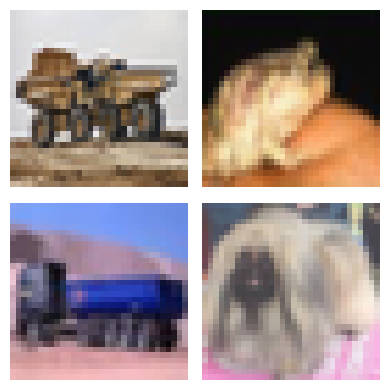

In [7]:
import matplotlib.pyplot as plt
import torchvision

# Assuming you have a test_loader DataLoader from PyTorch
num_images_to_plot = 4

# Define the number of rows and columns for the subplot grid
num_rows = (num_images_to_plot + 1) // 2  # Add 1 and floor division to ensure we have enough rows
num_cols = 2

# Create a new figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4, 4))

# Iterate over some batches (assuming test_loader contains batches)
for batch_idx, (images, _) in enumerate(test_loader):
    # Iterate over images in the batch
    for image_idx, image in enumerate(images):
        # Calculate the position in the subplot grid
        row_idx = (batch_idx * test_loader.batch_size + image_idx) // num_cols
        col_idx = (batch_idx * test_loader.batch_size + image_idx) % num_cols

        # Plot the image in the corresponding subplot
        axes[row_idx, col_idx].imshow(torchvision.utils.make_grid(image).permute(1, 2, 0))
        axes[row_idx, col_idx].axis('off')  # Turn off axis

        # Update counters
        num_images_to_plot -= 1

        # Check if we've plotted the desired number of images
        if num_images_to_plot <= 0:
            break

    # Check if we've plotted the desired number of images
    if num_images_to_plot <= 0:
        break

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Definición de métodos de ataque

In [8]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image

In [9]:
def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

## Generación de vectores de ataque

Realizar un estudio para la creación de vectores de ataque basados en el parámetro **epsilon**, utilizando el ataque FGSM anteriormente definido.

El tamaño mínimo de búsqueda será de **5 parámetros epsilon**, con el objetivo de optimizar los vectores de ataque basados en ejemplos adversarios.

In [10]:
epsilons = [0, 0.00001, 0.0001, 0.001, 0.005, .01, .05]

In [11]:
# RUN ATTACK
import warnings
warnings.filterwarnings('ignore')

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 3606 / 10000 = 0.3606
Epsilon: 1e-05	Test Accuracy = 3604 / 10000 = 0.3604
Epsilon: 0.0001	Test Accuracy = 3570 / 10000 = 0.357
Epsilon: 0.001	Test Accuracy = 3276 / 10000 = 0.3276
Epsilon: 0.005	Test Accuracy = 2372 / 10000 = 0.2372
Epsilon: 0.01	Test Accuracy = 1674 / 10000 = 0.1674
Epsilon: 0.05	Test Accuracy = 501 / 10000 = 0.0501


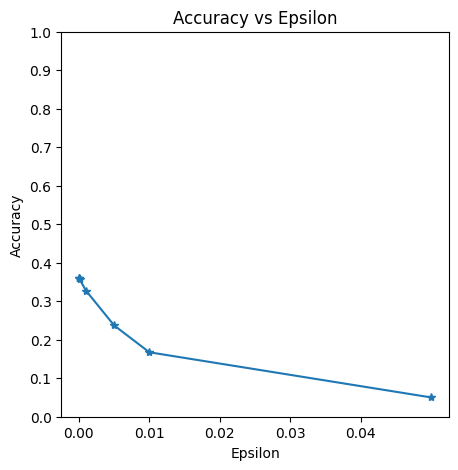

In [12]:
# RESULTS: Accuracy vs Epsilon

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, max(epsilons), step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Visualizar los ejemplos adversarios generados

Analizar los ejemplos adversarios: ¿existe algún patrón de comportamiento? ¿existe alguna relación entre medios de transporte y animales? ¿entre medios de transporte? ¿entre animales?

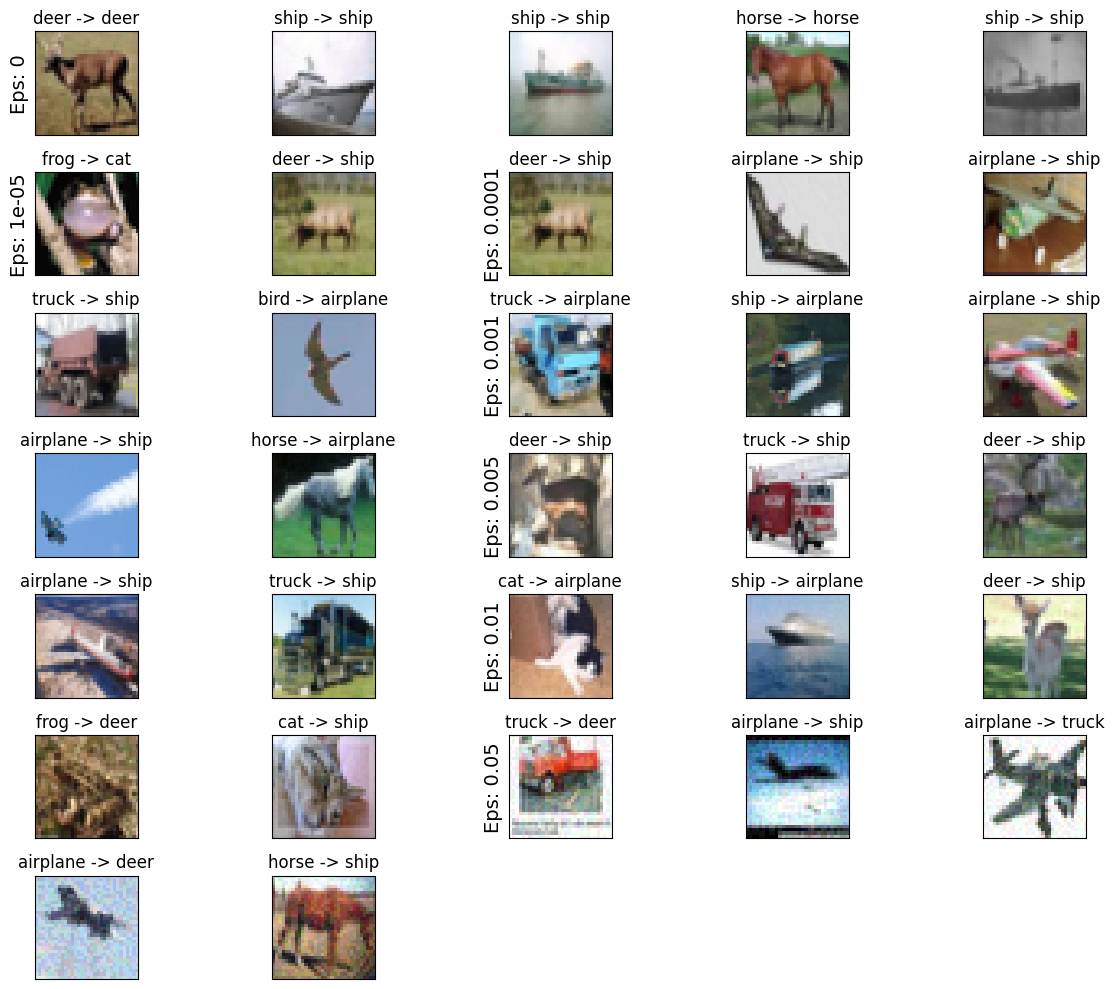

In [13]:
# PLOT SEVERAL EXAMPLES OF ADVERSARIAL SAMPLES AT EACH EPSILON

cnt = 0
plt.figure(figsize=(12,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(listclasses[orig], listclasses[adv]))
        plt.imshow(ex.transpose(1, 2, 0))
plt.tight_layout()
plt.show()

# Conclusiones

Detalle las conclusiones extraídas del presente estudio y generación de ejemplos adversarios.

*# Escriba aquí las conclusiones*